In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(style="ticks", palette="pastel")

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

# Normalizing the Data
from sklearn.preprocessing import MinMaxScaler

## Loading of dataset

In [2]:
path_default = "./data/stock_data.csv"
stock_data = pd.read_csv(path_default)
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.head(5)

,Date,Open,High,Low,Close,Volume,OpenInt,Stock
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,AAPL
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,AAPL
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,AAPL
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,AAPL
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,AAPL


In [3]:
companies = stock_data['Stock'].unique()
print(companies)

['AAPL' 'TSLA' 'MSFT' 'FB']


## Split training and test set

In [4]:
stocks ={}
for i in companies:
  stocks[i]= pd.DataFrame()
  stocks[i] = stocks[i].append((stock_data[stock_data['Stock'] == i][["Date", "Close"]]), ignore_index=True)
  print(stocks[i].head(5),stocks[i].shape)

        Date    Close
0 1984-09-07  0.42388
1 1984-09-10  0.42134
2 1984-09-11  0.42902
3 1984-09-12  0.41618
4 1984-09-13  0.43927 (8364, 2)
        Date  Close
0 2010-06-28  17.00
1 2010-06-29  23.89
2 2010-06-30  23.83
3 2010-07-01  21.96
4 2010-07-02  19.20 (1858, 2)
        Date    Close
0 1986-03-13  0.07533
1 1986-03-14  0.07533
2 1986-03-17  0.07533
3 1986-03-18  0.07533
4 1986-03-19  0.07533 (7983, 2)
        Date  Close
0 2012-05-18  38.23
1 2012-05-21  34.03
2 2012-05-22  31.00
3 2012-05-23  32.00
4 2012-05-24  33.03 (1381, 2)


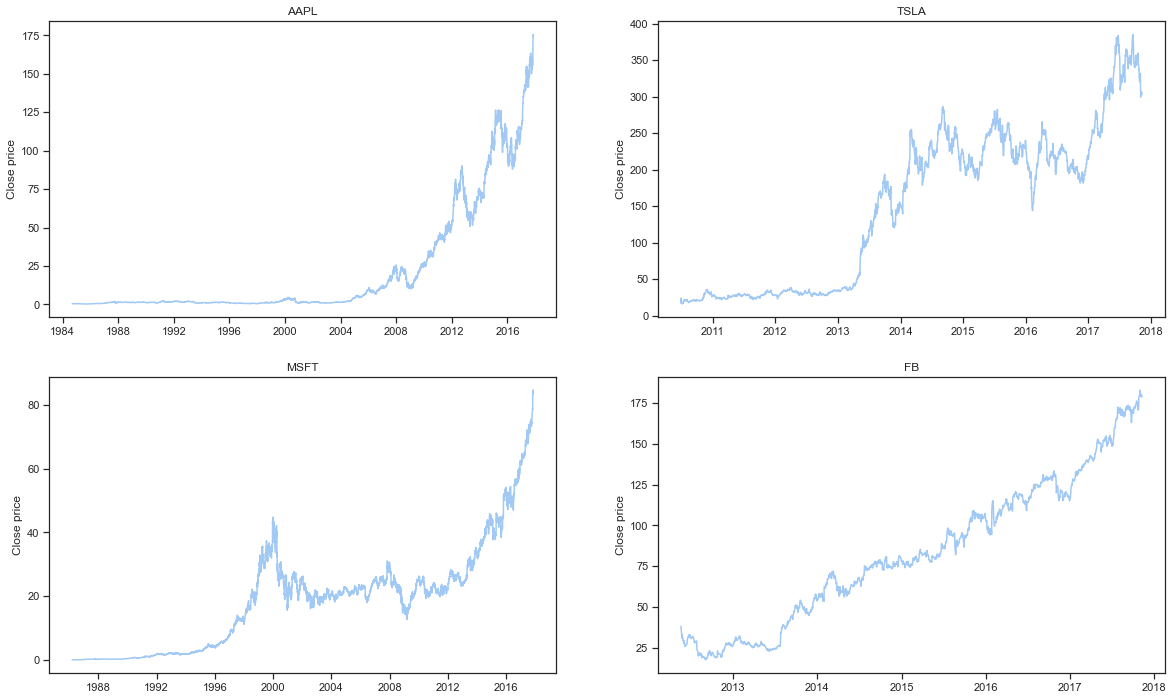

In [5]:
plt.figure(figsize=(20, 12))
for index, key in enumerate(companies):
  plt.subplot(2, 2, index + 1)
  plt.plot(stocks[key]["Date"], stocks[key]["Close"])
  plt.title(key)
  plt.ylabel('Close price')

In [6]:
scaler = MinMaxScaler()

In [7]:
def SplitData(data, time_slice):
    index_mark = int(len(data) * 0.8)
    close_train=data['Close'][0:index_mark].values
    X_train = []
    Y_train = []
    for i in range(index_mark - time_slice):
        X_train.append(close_train[i:i+time_slice])
        Y_train.append(close_train[i+time_slice])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = X_train.reshape((-1, 5, 1)) 
    Y_train = Y_train.reshape(-1, 1)

    close_test=data['Close'][index_mark:].values
    X_test = []
    Y_test = []
    for i in range(len(close_test) - time_slice):
        X_test.append(close_test[i:i+time_slice])
        Y_test.append(close_test[i+time_slice])
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    X_test = X_test.reshape((-1, 5, 1))
    Y_test = Y_test.reshape(-1, 1)

    return X_train, Y_train, X_test, Y_test

# AAPL_X_train, AAPL_Y_train, AAPL_X_test, AAPL_Y_test = SplitData(stocks['AAPL'], 5)

## Create model

In [8]:
def Model():
  model = tf.keras.models.Sequential(
      [
          tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
          tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
          tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
          tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
          tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
          tf.keras.layers.Dense(1, activation = tf.nn.leaky_relu)
      ]
  )
  return model

In [9]:
model = Model()

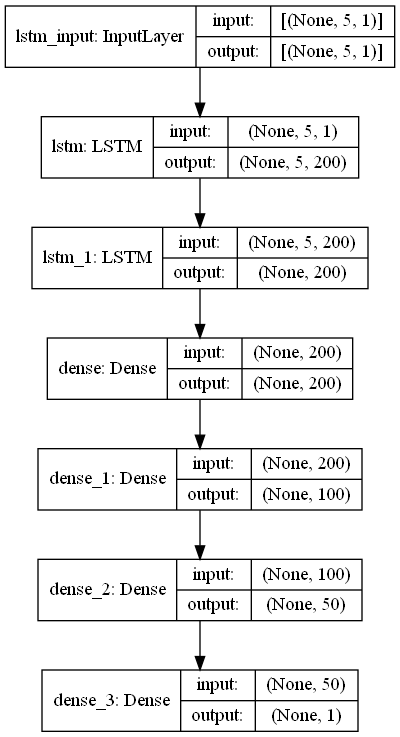

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 200)            161600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 200)               40200     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 547,801
Trainable params: 547,801
Non-trainable params: 0
__________________________________________________

## Custom Learning Rate

In [12]:
def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)
  
  return lrate

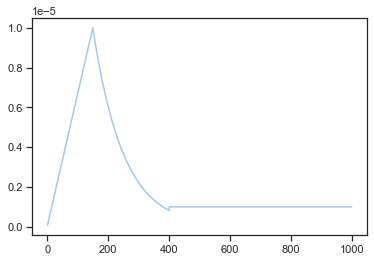

In [13]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)
plt.show()

In [14]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Train model

### Apple model

In [15]:
AAPL_X_train, AAPL_Y_train, AAPL_X_test, AAPL_Y_test = SplitData(stocks['AAPL'], 5)

In [16]:
AAPL_Model = Model()

In [17]:
AAPL_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [18]:
import time
# Measuring the time taken by the model to train
StartTime=time.time()
AAPL_hist = AAPL_Model.fit(AAPL_X_train, AAPL_Y_train, epochs = 100, validation_data = (AAPL_X_test, AAPL_Y_test), callbacks=[callback])
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/100
209/209 [==============================] - 8s 21ms/step - loss: 102.5797 - root_mean_squared_error: 10.1255 - val_loss: 8744.1543 - val_root_mean_squared_error: 93.5102
Epoch 2/100
209/209 [==============================] - 3s 14ms/step - loss: 108.6407 - root_mean_squared_error: 10.4187 - val_loss: 8732.1436 - val_root_mean_squared_error: 93.4459
Epoch 3/100
209/209 [==============================] - 3s 14ms/step - loss: 97.8630 - root_mean_squared_error: 9.8903 - val_loss: 8707.6709 - val_root_mean_squared_error: 93.3149
Epoch 4/100
209/209 [==============================] - 3s 14ms/step - loss: 102.0195 - root_mean_squared_error: 10.0996 - val_loss: 8670.0908 - val_root_mean_squared_error: 93.1133
Epoch 5/100
209/209 [==============================] - 3s 15ms/step - loss: 95.9234 - root_mean_squared_error: 9.7888 - val_loss: 8619.9912 - val_root_mean_squared_error: 92.8439
Epoch 6/100
209/209 [==============================] - 3s 12ms/step - loss: 94.8721 - root_mean_squ

In [19]:
AAPL_Model.save('./model/AAPL/AAPL_model.h5')

In [20]:
history_dict = AAPL_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

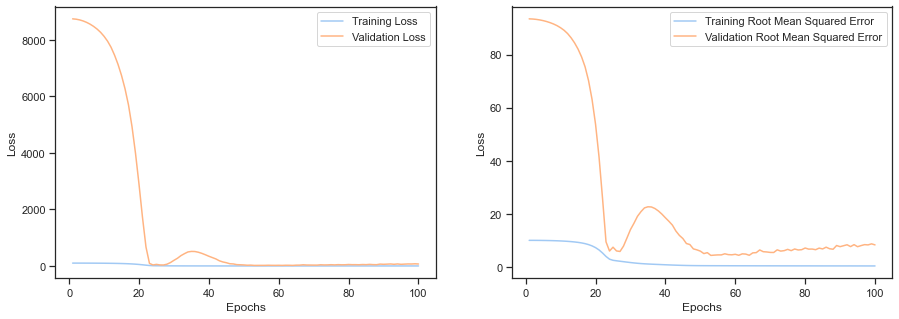

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Apple

In [22]:
AAPL_prediction = AAPL_Model.predict(AAPL_X_test).reshape(-1,1)

In [23]:
# plt.figure(figsize=(20, 5))
# plt.plot(stocks['AAPL']['Date'][stocks['AAPL']['Date'] < date_mark], 
#         stocks['AAPL']['Close'][stocks['AAPL']['Date'] < date_mark], label = 'Training')

# plt.plot(stocks['AAPL']['Date'][stocks['AAPL']['Date'] >= date_mark], 
#         stocks['AAPL']['Close'][stocks['AAPL']['Date'] >= date_mark], label = 'Testing')

# plt.plot(stocks['AAPL']['Date'][stocks['AAPL']['Date'] >= "2017-01-13"], 
#         AAPL_prediction.reshape(-1), label = 'Predictions')

# plt.xlabel('Time')
# plt.ylabel('Closing Price')
# plt.legend(loc = 'best')

In [31]:
from sklearn.metrics import r2_score
r2 = r2_score(AAPL_Y_test, AAPL_prediction)
rmse = math.sqrt(mean_squared_error(AAPL_Y_test, AAPL_prediction))
mape = np.mean(np.abs(AAPL_prediction - AAPL_Y_test)/np.abs(AAPL_Y_test))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2 score: {r2}')

RMSE: 8.311256911549936
MAPE: 0.05700497220790002
R2 score: 0.9292897687051892


### Tesla model

In [28]:
TSLA_X_train, TSLA_Y_train, TSLA_X_test, TSLA_Y_test = SplitData(stocks['TSLA'], 5)

### Microsoft model

In [29]:
MSFT_X_train, MSFT_Y_train, MSFT_X_test, MSFT_Y_test = SplitData(stocks['MSFT'], 5)

### Facebook model

In [30]:
FB_X_train, FB_Y_train, FB_X_test, FB_Y_test = SplitData(stocks['FB'], 5)